# Experiments with the simulated data, where a naive baseline was added to the varying peak sizes, with noise in the signal, to simulate real world Raman Spectra.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
mat_data = loadmat('Voigt_NaiveBaseline.mat')
print(type(mat_data))

# take the data and club it in one ndarray 
X_1 = mat_data['Type1']
Targets1 = mat_data['Target1']
Targets1 = Targets1.T
print(Targets1.shape)
X_1 = np.append(X_1,Targets1,axis=1)
print(X_1.shape)

X_2 = mat_data['Type2']
Targets2 = mat_data['Target2']
Targets2 = Targets2.T
print(Targets2.shape)
X_2=np.append(X_2,Targets2,axis=1)
print(X_1.shape)

X_3 = mat_data['Type3']
Targets3 = mat_data['Target3']
Targets3 = Targets3.T
print(Targets3.shape)
X_3 = np.append(X_3,Targets3,axis=1)
print(X_3.shape)

X = np.concatenate((X_1,X_2,X_3))
print(X.shape)
print(X[22,1000])

# Randomly shuffling the inputs
print(X[:,1000])
np.take(X,np.random.permutation(X.shape[0]),axis=0,out=X)
print(X[:,1000])

# Separation of y and X values
y=X[:,1000]
print(y,y.shape)
X=X[:,0:1000]


<class 'dict'>
(21, 1)
(21, 1001)
(21, 1)
(21, 1001)
(21, 1)
(21, 1001)
(63, 1001)
2.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[2. 1. 1. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 2. 2. 1. 2. 1. 1. 2. 1. 1. 1. 1.
 2. 0. 1. 0. 2. 0. 1. 2. 2. 0. 0. 2. 0. 1. 0. 1. 2. 2. 1. 0. 0. 1. 2. 2.
 1. 1. 2. 0. 2. 1. 2. 0. 1. 1. 0. 1. 0. 2. 2.]
[2. 1. 1. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 2. 2. 1. 2. 1. 1. 2. 1. 1. 1. 1.
 2. 0. 1. 0. 2. 0. 1. 2. 2. 0. 0. 2. 0. 1. 0. 1. 2. 2. 1. 0. 0. 1. 2. 2.
 1. 1. 2. 0. 2. 1. 2. 0. 1. 1. 0. 1. 0. 2. 2.] (63,)


In [3]:
# LOAD the data and reshape 
nchannels = 1 
rows = X.shape[1]
print(X.shape)
x_train = X[:40].astype('float32')
x_train = x_train.reshape((-1, nchannels, rows))
targets_train = y[:40].astype('int32')

x_valid = X[40:55].astype('float32')
x_valid = x_valid.reshape((-1, nchannels, rows))
targets_valid = y[40:55].astype('int32')

x_test = X[55:63].astype('float32')
x_test = x_test.reshape((-1, nchannels, rows))
targets_test = y[55:63].astype('int32')

print("Information on dataset")
print("x_train", x_train.shape)
print("targets_train", targets_train.shape)
print("x_valid", x_valid.shape)
print("targets_valid", targets_valid.shape)
print("x_test", x_test.shape)
print("targets_test", targets_test.shape)
print("The test targets are:",targets_test)
print("The training targets are:",targets_train)
print("The validation targets are:",targets_valid)

(63, 1000)
Information on dataset
x_train (40, 1, 1000)
targets_train (40,)
x_valid (15, 1, 1000)
targets_valid (15,)
x_test (8, 1, 1000)
targets_test (8,)
The test targets are: [0 1 1 0 1 0 2 2]
The training targets are: [2 1 1 0 0 0 2 0 0 2 0 0 0 2 2 1 2 1 1 2 1 1 1 1 2 0 1 0 2 0 1 2 2 0 0 2 0
 1 0 1]
The validation targets are: [2 2 1 0 0 1 2 2 1 1 2 0 2 1 2]


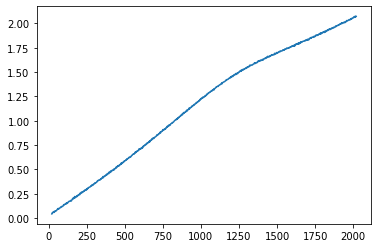

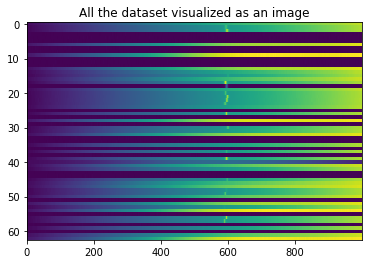

In [4]:
spectrum = x_train[0, 0, :]
Shift_values = np.linspace(20,2020,1000)
plt.plot(Shift_values, spectrum)
plt.show()
plt.title('All the dataset visualized as an image')
plt.imshow(X,aspect='auto')

# Initialize and training of the neural net

In [5]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d, BatchNorm1d, Conv1d, MaxPool1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [6]:
# hyperameters of the model
num_classes = 3
channels = x_train.shape[1]
height = x_train.shape[2]

num_filters_conv1 = 2
kernel_size_conv1 = 10 
stride_conv1 = 1 
padding_conv1 = 0

num_l1 = 1000

num_filters_conv2 = 16
kernel_size_conv2 = 4
stride_conv2 = 1
padding_conv2 = 0

kernel_size_pooling1 = 2
stride_pooling1 = 1
padding_pooling1 = 0
   
    
def compute_conv_dim(dim_size, k, p, s):
    """
    out_dim = (input_dim - filter_dim + 2padding) / stride + 1 after convolution
    """
    return int((dim_size - k + 2 * p) / s + 1)


def compute_pool_dim(dim_size, kp, pp, sp):
    """
    out_dim = (input_dim - filter_dim + 2padding) / stride + 1 after pooling
    """
    return int((dim_size - kp + 2 * pp) / sp + 1)


# define network
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv1d(in_channels=channels,
                             out_channels=num_filters_conv1,
                             kernel_size=kernel_size_conv1,
                             padding=padding_conv1,
                             stride=stride_conv1)
        self.conv_out_height = compute_conv_dim(height, kernel_size_conv1, padding_conv1, 
                                                                 stride_conv1)
        
        self.l1_in_features = num_filters_conv1 * self.conv_out_height 

        self.l_out = Linear(in_features=self.l1_in_features, 
                            out_features=num_classes,
                            bias=True)
        
    def forward(self, x): 
        x = relu(self.conv_1(x))
        # the size -1 is inferred from other dimensions 
        x = x.view(-1, self.l1_in_features)
        return softmax(self.l_out(x), dim=1)

net = Net()
print(net)

Net(
  (conv_1): Conv1d(1, 2, kernel_size=(10,), stride=(1,))
  (l_out): Linear(in_features=1982, out_features=3, bias=True)
)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [10]:
# Test the forward pass with dummy data
x = np.random.normal(0, 1, (5, 1, 1000)).astype('float32')
out = net(Variable(torch.from_numpy(x)))
out.size(), out, out.dtype

(torch.Size([5, 3]), tensor([[0.3126, 0.2913, 0.3960],
         [0.3699, 0.2774, 0.3527],
         [0.3391, 0.3736, 0.2873],
         [0.3196, 0.2768, 0.4036],
         [0.2889, 0.3749, 0.3363]], grad_fn=<SoftmaxBackward>), torch.float32)

Notice how the output's probabilities are nicely distributed.
The built-in nn functions (layers) alreay have a sane initialization of the weights.

Epoch  1 : Train Loss 0.415588 , Train acc 0.675000, Valid acc 0.600000
Epoch 11 : Train Loss 0.293513 , Train acc 0.875000, Valid acc 0.900000
Epoch 21 : Train Loss 0.280661 , Train acc 0.875000, Valid acc 0.900000
Epoch 31 : Train Loss 0.273910 , Train acc 0.900000, Valid acc 0.900000
Epoch 41 : Train Loss 0.269000 , Train acc 0.900000, Valid acc 0.900000
Epoch 51 : Train Loss 0.265175 , Train acc 0.900000, Valid acc 0.900000
Epoch 61 : Train Loss 0.262137 , Train acc 0.900000, Valid acc 0.900000
Epoch 71 : Train Loss 0.259694 , Train acc 0.925000, Valid acc 0.900000
Epoch 81 : Train Loss 0.257701 , Train acc 0.925000, Valid acc 0.900000
Epoch 91 : Train Loss 0.256037 , Train acc 0.925000, Valid acc 0.900000
Epoch 101 : Train Loss 0.254629 , Train acc 0.950000, Valid acc 0.900000
Epoch 111 : Train Loss 0.253810 , Train acc 0.950000, Valid acc 0.900000
Epoch 121 : Train Loss 0.255560 , Train acc 0.925000, Valid acc 0.900000
Epoch 131 : Train Loss 0.253131 , Train acc 0.950000, Valid a

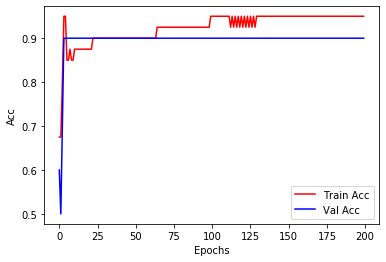


Test set Acc:  1.000000


In [11]:
from sklearn.metrics import accuracy_score
batch_size = 10
num_epochs = 200
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []
losses_valid = []
cur_loss_valid = 0

# creating a numpy array to store the output probabilities
output_probs=np.ones((1,3),dtype=np.float32)

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        output = net(x_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    # Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    # Evaluate validation
    val_preds, val_targs = [], []
    curr_loss_valid = 0
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
        output = net(x_batch)
        preds = torch.max(output, 1)[1]
        
        val_preds += list(preds.data.numpy())
        val_targs += list(targets_valid[slce])
        # Taking the output probabilities and storing them in a numpy array
        output_probs=np.append(output_probs,output.data.numpy(),axis=0)
            
    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))
        
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Acc', 'Val Acc'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.show()

# Evaluate test set
x_batch = Variable(torch.from_numpy(x_test))
output = net(x_batch)
preds = torch.max(output, 1)[1]
print("\nTest set Acc:  %f" % (accuracy_score(list(targets_test), list(preds.data.numpy()))))

In [12]:
print(train_targs)
print(train_preds)

[2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 2, 2, 0, 0, 2, 0, 1, 0, 1]
[2, 1, 1, 0, 0, 0, 2, 0, 0, 2, 0, 0, 0, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 1, 0, 2, 0, 1, 1, 2, 0, 0, 2, 0, 1, 0, 1]


# Visualisation of failed predictions and that of learned weights

(array([ 0,  1,  2,  6,  9, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       26, 28, 30, 31, 32, 35, 37, 39]),)
(25, 1, 1000)


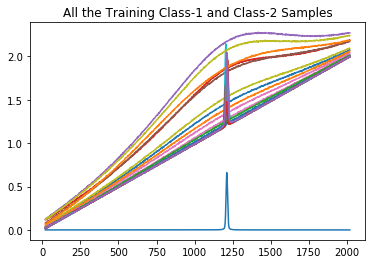

(25, 1, 1000)


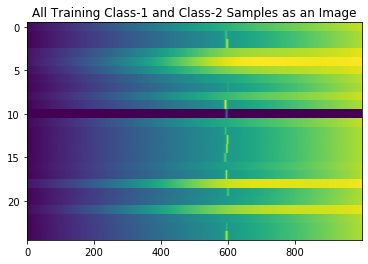

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(array([18, 31]),)


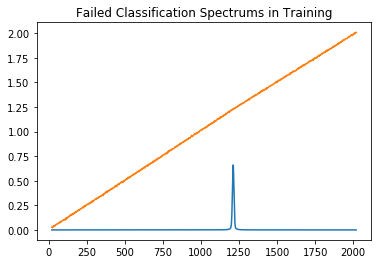

-----Checking for any Low intensity signals------
None of Spectra has Amplitude less than 0.2


In [13]:
# Visualising all the training Class-1 and Class-2 Samples.
a=np.where(targets_train!=0)
print(a)
All_Target12 = x_train[a]
print(All_Target12.shape)
for i in All_Target12:
    plt.plot(Shift_values,i[0,:])    
plt.title("All the Training Class-1 and Class-2 Samples")
plt.show()    
print(All_Target12.shape)
plt.title("All Training Class-1 and Class-2 Samples as an Image")
plt.imshow(All_Target12[:,0,:], aspect='auto')
plt.show()

#Visualising all the Failed Training Samples
train_targs_array = np.asarray(train_targs)
print(type(train_targs_array))
train_preds_array = np.asarray(train_preds)
print(type(train_preds_array))
Failed_indices = np.where(train_targs_array != train_preds_array)
print(Failed_indices)
Failed_Spectrum = x_train[Failed_indices]
plt.title("Failed Classification Spectrums in Training")
for i in Failed_Spectrum:
    plt.plot(Shift_values, i[0,:])
plt.show()



print("-----Checking for any Low intensity signals------")
Counter = 0
for i in All_Target12:
    if max(i[0, :])<=0.2:
        plt.plot(Shift_values, i[0,:])
        Counter = Counter + 1
    else:
        continue
if Counter == 0:
    print("None of Spectra has Amplitude less than 0.2")

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(array([0]),)


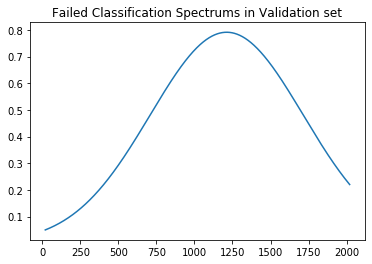

(array([ 0,  1,  2,  5,  6,  7,  8,  9, 10, 12, 13, 14]),)
(12, 1, 1000)


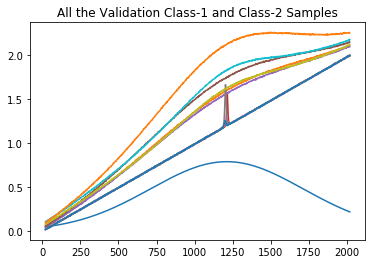

-----Checking for any Low intensity signals------
None of Spectra has Amplitude less than 0.2


In [14]:
# Doing the same for the validation set
val_targs_array = np.asarray(val_targs)
print(type(val_targs_array))
val_preds_array = np.asarray(val_preds)
print(type(val_preds_array))
Failed_indices = np.where(val_targs_array != val_preds_array)
print(Failed_indices)
Failed_Spectrum = x_valid[Failed_indices]
plt.title("Failed Classification Spectrums in Validation set")
for i in Failed_Spectrum:
    plt.plot(Shift_values, i[0,:])
plt.show()

# All the Validation Class-2 and Class-1 Samples
abc = np.where(targets_valid!=0)
print(abc)
All_Target12_valid=x_valid[abc]
print(All_Target12_valid.shape)
for i in All_Target12_valid:
    plt.plot(Shift_values,i[0,:])    
plt.title("All the Validation Class-1 and Class-2 Samples") 
plt.show() 

# Checking low intensity validation set signals
print("-----Checking for any Low intensity signals------")
Counter=0
for i in All_Target12_valid:
    if max(i[0,:])<=0.2:
        plt.plot(Shift_values,i[0,:])
        Counter=Counter+1
    else:
        continue
if Counter==0:
    print("None of Spectra has Amplitude less than 0.2")

In [15]:
print("The failed indices in the validation were:",Failed_indices)
Output_probs=output_probs[1:]
print("Let us visualize the output probabilities at these failed sites:")
print("Size of Output probabilities array:",Output_probs.shape)
Lastepoch_Output_probs=Output_probs[Output_probs.shape[0]-15:]
print("After clipping for the last epoch on the validation set: ",Lastepoch_Output_probs.shape)
print("-----------------------")
print("The failed Classification probabilities are:",Lastepoch_Output_probs[Failed_indices])
print("The correct Classification should have been:",val_targs_array[Failed_indices])

The failed indices in the validation were: (array([8, 9]),)
Let us visualize the output probabilities at these failed sites:
Size of Output probabilities array: (2000, 3)
After clipping for the last epoch on the validation set:  (15, 3)
-----------------------
The failed Classification probabilities are: [[1.5584654e-04 9.2938638e-01 7.0457697e-02]
 [1.1122680e-03 1.1532726e-02 9.8735505e-01]]
The correct Classification should have been: [1 2]


The shape of sample spectrum (1, 1000)
The output of the neural network is: tensor([[0.0026, 0.0151, 0.9823]])


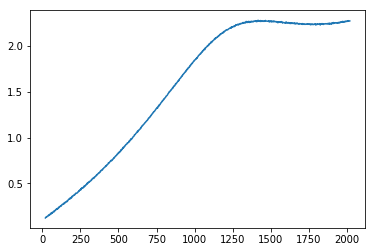

In [16]:
# Visualising the filters and the feature maps
# Taking a sample first
sample_spec = x_test[1]
print("The shape of sample spectrum",sample_spec.shape)
plt.plot(Shift_values,sample_spec[0,:])
sample_spec=sample_spec.reshape(-1,1,1000)
a=net(torch.from_numpy(sample_spec))
print("The output of the neural network is:",a.data)


In [17]:
from torch.nn.functional import conv1d
input_tensor=torch.from_numpy(sample_spec)
filter1=net.conv_1.weight.data
Output_convolution=relu(net.conv_1(input_tensor))
print("The Feature maps generated after the convolution operation is:",Output_convolution.shape)
print("The filters have a tensor size of",filter1.shape)
print("The Bias Term:",net.conv_1.bias.data)

The Feature maps generated after the convolution operation is: torch.Size([1, 2, 991])
The filters have a tensor size of torch.Size([2, 1, 10])
The Bias Term: tensor([-0.0958,  0.4694])


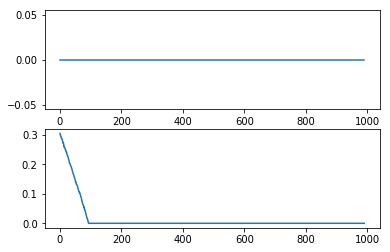

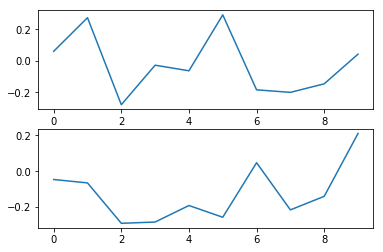

In [18]:
plt.figure()
for i in range(Output_convolution.shape[1]):
    plt.subplot(num_filters_conv1,1,i+1)
    plt.plot(Output_convolution[0,i,:].data.numpy())
plt.show()    

plt.figure()
plt.title("The Filters visualised on a graph")
for i in range(filter1.shape[0]):
    plt.subplot(num_filters_conv1,1,i+1)
    plt.plot(filter1[i,0,:].data.numpy())
plt.show()

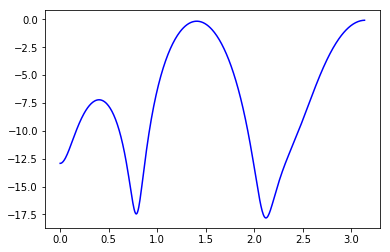

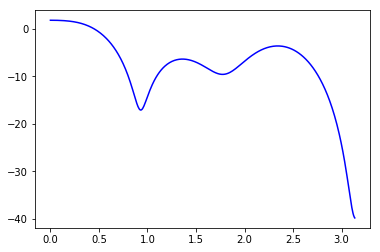

This is the transfer function of the system
<class 'numpy.ndarray'>


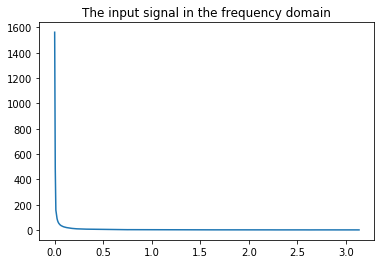

In [19]:
from scipy.signal import freqz
for i in range(filter1.shape[0]):
    w,h=freqz(filter1[i,0,:].data.numpy())
    plt.plot(w,20*np.log10(abs(h)),'b')
    plt.show()
print("This is the transfer function of the system")
print(type(sample_spec))
w_input,h_input=freqz(sample_spec[0,0,:])
plt.title("The input signal in the frequency domain")
plt.plot(w_input,abs(h_input))    

In [20]:
print("Checking the same for Pooling layer")
try:
    Output_maxpool=net.maxpool_1(Output_convolution)
    print("The size of the feature maps after pooling is",net.conv_out_height)
    for i in range(filter1.shape[0]):
        plt.subplot(2,2,i+1)
        plt.plot(Output_maxpool[0,i,:].data.numpy())
    plt.show()
except AttributeError:
    print("There isnt a pooling layer present")


Checking the same for Pooling layer
There isnt a pooling layer present


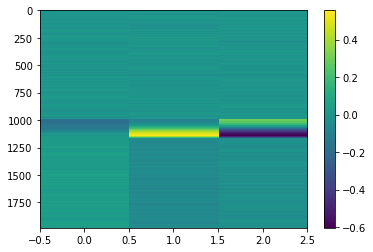

In [21]:
plt.imshow(net.l_out.weight.data.numpy().T,aspect='auto')
plt.colorbar()